## Naive Bayes Classifier ##
This code constructs a naive Bayes classifier to classify sentences in our corpus as pertaining to threats or recommendations for the conservation of invertebrate species.

In [53]:
!pip install scikit-learn

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metada

In [3]:
# Load the required libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
import re
import string

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# Custom functions:

# Remove proper nouns
def remove_proper(data):
    tagged_sentence = nltk.tag.pos_tag(data.split())
    edited_sentence = [word for word, tag in tagged_sentence if tag != "NNP" and tag != "NNPS"]
    edited_sentence = ' '.join(edited_sentence)
    return edited_sentence

# Remove non-English words
def remove_nonEnglish(data):
    words = set(nltk.corpus.words.words())
    original_sentence = data.split()
    edited_sentence = [word for word in original_sentence if word in words]
    edited_sentence = ' '.join(edited_sentence)
    return edited_sentence

# Grab n-grams
def extract_ngrams(data, num):
    n_grams = ngrams(word_tokenize(data), num)
    return n_grams


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vmshi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
# Import the training and validation data, clean it, and split it into training and validation datasets
from nltk.stem import WordNetLemmatizer
import pandas as pd
lemma = WordNetLemmatizer()
    
annotations = pd.read_csv("../data/sentenceData.csv", encoding='cp1252')
annotations = annotations[annotations['class'].notnull()]

# Tokenize, lowercase, and lemmatize
annotations['sentence'] = annotations['sentence'].apply(remove_proper)
annotations['sentence'] = annotations['sentence'].apply(word_tokenize)
annotations['sentence'] = annotations['sentence'].apply(lambda x: [word.lower() for word in x])
annotations['sentence'] = annotations['sentence'].apply(lambda x: [lemma.lemmatize(word) for word in x])

# Drop punctuation
punc = string.punctuation
annotations['sentence'] = annotations['sentence'].apply(lambda x: [word for word in x if word not in punc])

# Drop stop words
stop_words = set(stopwords.words('english'))
annotations['sentence'] = annotations['sentence'].apply(lambda x: [word for word in x if word not in stop_words])

# Keep only English words
words = set(nltk.corpus.words.words())
annotations['sentence'] = annotations['sentence'].apply(lambda x: [word for word in x if word in words])

# Format the data into a feature matrix
corpus = annotations.iloc[:,0].values

def dummy_fun(doc):
    return doc

cv = CountVectorizer(max_features = 5000, lowercase=False, tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)
x = cv.fit_transform(corpus).toarray()
y = annotations.iloc[:,1].values

# Split the feature matrix and labels into training and validation data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.20)

In [12]:
# Now fit the multinomial naive Bayes classifier to the training data
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

MultinomialNB()

In [13]:
# Try a support vector machine as well
from sklearn.linear_model import SGDClassifier
classifier_svm = SGDClassifier(loss = "hinge", penalty = "l2", alpha = 0.001, max_iter = 1000)
classifier_svm.fit(x_train, y_train)

SGDClassifier(alpha=0.001)

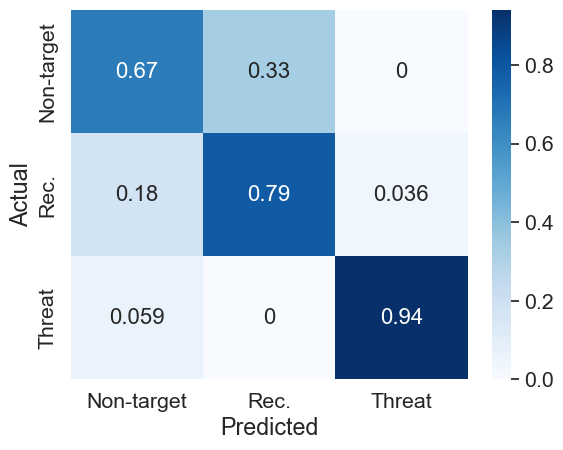

In [16]:
# Evaluate the performance from the confusion matrix on the validation data
y_pred = classifier.predict(x_valid)
y_pred_svm = classifier_svm.predict(x_valid)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

result = confusion_matrix(y_valid, y_pred, normalize = "true")

import seaborn as sn
df_cm = pd.DataFrame(result, range(3), range(3))
sn.set(font_scale = 1.4)
g = sn.heatmap(df_cm, annot=True, annot_kws={'size':16}, cmap="Blues")
g.set_xticklabels(['Non-target', 'Rec.', 'Threat'])
g.set_yticklabels(['Non-target', 'Rec.', 'Threat'])
g.set(xlabel = "Predicted", ylabel = "Actual")
plt.show()

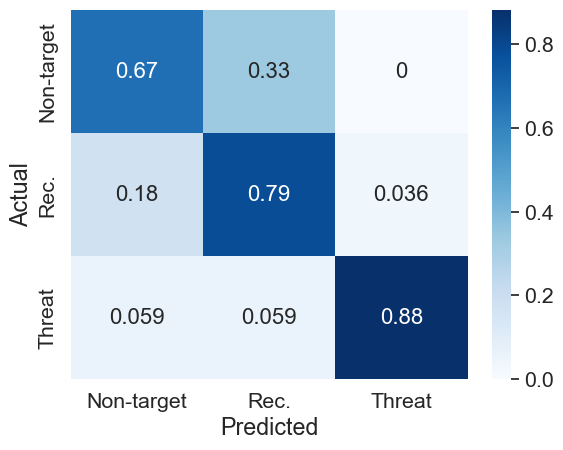

In [17]:
result = confusion_matrix(y_valid, y_pred_svm, normalize = "true")

import seaborn as sn
df_cm = pd.DataFrame(result, range(3), range(3))
sn.set(font_scale = 1.4)
g = sn.heatmap(df_cm, annot=True, annot_kws={'size':16}, cmap="Blues")
g.set_xticklabels(['Non-target', 'Rec.', 'Threat'])
g.set_yticklabels(['Non-target', 'Rec.', 'Threat'])
g.set(xlabel = "Predicted", ylabel = "Actual")
plt.show()

In [18]:
# Output accuracy and recall metrics
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred, average="micro")

print("Accuracy: ", round(accuracy, 2))
print("Recall: ", round(recall, 2))

Accuracy:  0.82
Recall:  0.82


In [19]:
# Output accuracy and recall metrics
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_valid, y_pred_svm)
recall = recall_score(y_valid, y_pred_svm, average="micro")

print("Accuracy: ", round(accuracy, 2))
print("Recall: ", round(recall, 2))

Accuracy:  0.8
Recall:  0.8


In [10]:
annotations = pd.read_csv("../data/sentenceData.csv", encoding='cp1252')

# Drop punctuation
punc = string.punctuation
annotations['sentence'] = annotations['sentence'].str.translate(str.maketrans('', '', string.punctuation))

# Remove proper nouns
annotations['sentence'] = annotations['sentence'].apply(remove_proper)

# Remove non-English words
annotations['sentence'] = annotations['sentence'].apply(remove_nonEnglish)

# Lowercase
annotations['sentence'] = annotations['sentence'].str.lower()

# Extract 2-grams
annotations['sentence'] = annotations['sentence'].apply(extract_ngrams, num = 2)

# Format the data into a feature matrix
corpus = annotations.iloc[:,0].values

def dummy_fun(doc):
    return doc

cv = CountVectorizer(max_features = 5000, lowercase=False, tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)
x = cv.fit_transform(corpus).toarray()
y = annotations.iloc[:,1].values

# Split the feature matrix and labels into training and validation data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.20, random_state=0)

# Now fit the multinomial naive Bayes classifier to the training data
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

# Output accuracy and recall metrics
from sklearn.metrics import accuracy_score, recall_score
y_pred = classifier.predict(x_valid)

accuracy = accuracy_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred, average="micro")

print("Accuracy: ", round(accuracy, 2))
print("Recall: ", round(recall, 2))

Accuracy:  0.7
Recall:  0.7
